In [2]:
import numpy,random

In [3]:
def unpickle(file):
    import pickle
    with open(file,'rb') as f:
        dict = pickle.load(f,encoding='bytes')
    return dict

###TRANSFORMATION FUNCTION IMPLEMENTATION

DATA LOADING

In [ ]:
import os
path = "/Data/cifar-10-batches-py/"

data  =  []      #Images
label =  []      #Label

data_test = []
label_test = []

for file in os.listdir(path):

  if(file.startswith('data')):
    dataset = unpickle(path+file)
    label.extend(dataset[b'labels'])
    data.extend(dataset[b'data'])

  if(file.startswith('test')):
    dataset = unpickle(path+file)
    label_test.extend(dataset[b'labels'])
    data_test.extend(dataset[b'data'])

IMAGE DISPLAY FUNCTION

In [5]:
from matplotlib import pyplot

def image_ArrayDisplay(image):
    image_array = numpy.reshape(image,(3,32,32)).transpose(1,2,0)
    print(image_array)

def image_display(image):
    image_array = numpy.reshape(image,(3,32,32)).transpose(1,2,0)
    img = pyplot.imshow(image_array)

1) Image Enhancement

In [29]:
# Enhancing a single PIXEL
def enhance_Pixel(i,factor,min_pixel):
       return ( int( (i-min_pixel) / (factor) ) )
    
# Enhancing an IMAGE
def enhance_Image(image):
    max_pixel=max(image) 
    min_pixel=min(image)
    factor = int(255/(max_pixel-min_pixel) )
    functionality = numpy.vectorize(enhance_Pixel,excluded=['factor','min_pixel'])
    return functionality(image,factor,min_pixel)


In [ ]:
#  Demonstration of Image Enhancement by applying on example image
image = data[100]
new_image =  enhance_Image(image)
image_display(new_image)

2) Image Posterization 

In [30]:
# Posterization for a PIXEL
def posterization_Pixel(i,divider,desired_min):
        i = int(i)/divider
        i = int(i)+desired_min
        return int(i if i<=255 and i>=0 else 255 if i>255 else 0)

# Posterization for an IMAGE    
def posterize_Image(image,desired_max,desired_min):
    r = desired_max - desired_min
    divider = int(255/r)
    functionality = numpy.vectorize(posterization_Pixel,excluded=['divider','desired_min'])
    return functionality(image,divider,desired_min)

In [ ]:
#  Demonstration of Image Posterization by applying on example image
image = data[100]
new_image =  posterize_Image(image,200,50)
image_display(new_image)

3) Random Rotate Image


In [31]:
def rotate_Image(image,angle):

    import math
    
    image = numpy.reshape(image,(3,32,32)).transpose(1,2,0)
    height=image.shape[0]                                   
    width=image.shape[1]
         
    angle_in_rad=math.radians(angle)                           
    
    cos=math.cos(angle_in_rad)
    sin=math.sin(angle_in_rad)

    # height and width of the new image
    
    output_image = numpy.zeros((height,width,image.shape[2]),dtype='uint8')

    # centre of the image about which we have to rotate the image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    
    original_centre_width    = round(((image.shape[1]+1)/2)-1)   


    for i in range(height):
        for j in range(width):
            #co-ordinates of pixel with respect to the centre of original image
            y = height - i - 1 - original_centre_height                   
            x = width - j - 1 - original_centre_width                      

            #co-ordinate of pixel with respect to the rotated image
            new_y=round(-x * sin + y*cos)
            new_x=round( x*cos + y*sin)

            #change new_x and new_y with respect to the centre
            new_y = original_centre_height - new_y
            new_x = original_centre_width - new_x
            
            if 0 <= new_x < width and 0 <= new_y < height:
                output_image[new_y,new_x,:]=image[i,j,:]   

    # pyplot.imshow(output_image)
    # convert the image to the data[i] format
    output_image=output_image.transpose(2,0,1)
    output = numpy.reshape( output_image,(3072) )
    return output

In [ ]:
# Demonstration of Rotate Image applying on example image
image = data[100]
new_image =  rotate_Image(image,15)
image_display(new_image)

4) Changing Contrast  x′(i, j, c) = α ·(x(i, j, c)−128)+128 and flip image with 0.5 probability


In [32]:
# HORINZONTAL FLIP AN IMAGE
def flip_hor_Image(image):
    ptr=0
    size=32
    while ptr< len(image):
        image[ptr:ptr+size]=numpy.flip(image[ptr:ptr+size])
        ptr+=size
        
    return image

# Changing Contrast for a PIXEL
def change_contrast_Pixel(i,alpha):
    i = alpha*( int(i) - 128) +128 
    return int(i if i<=255 and i>=0 else 255 if i>255 else 0)

# Changing Contrast for an IMAGE + flip image with 0.5 probability
def change_contrast_and_flip_Image(image):
    alpha = random.uniform(0.5,2.0)  # alpha should be between 0.5 and 2.0
    functionality = numpy.vectorize(change_contrast_Pixel,excluded=['alpha'])
    image = functionality(image,alpha)
    #flip image with 0.5 probability
    flip = random.uniform(0,1)
    if flip >= 0.5:
        image = flip_hor_Image(image)
    return image

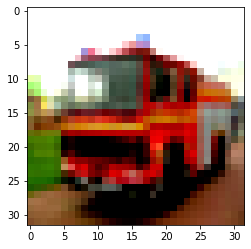

In [ ]:
# Demonstration of Changing Contrast + flip by applying on example image
image = data[100]
new_image =  change_contrast_and_flip_Image(image)
image_display(new_image)

CREATING AUGMENTED DATASET BY APPLYING RANDOM TRANSFORMATIONS

In [33]:
# Applying tranformation to all images and creating a new dataset
# 
# -------FUNCTIONS--------
#   1   :   enhance_Image() 
#   2   :   posterize_Image()
#   3   :   rotate_Image()
#   4   :   change_contrast_and_flip_Image()  

def tranform_dataset( data, label):
  transformed_images = []
  transformed_images_label = []

  for i in range(len(data)):
      #Saving the label of the image
      transformed_images_label.append( label[i] )
      
      #Creating a random int to decide which transformation to apply
      function_choice = random.randint(1,4)
      
      if function_choice == 1:
          transformed_images.append( enhance_Image(data[i]) )
      elif function_choice == 2:
          # posterize_Image(image,desired_max,desired_min)
          transformed_images.append( posterize_Image(data[i], 200, 50 ))
      elif function_choice == 3:
          # rotate_Image(image,angle) by 90 deg
          transformed_images.append( rotate_Image(data[i],90) )
      elif function_choice == 4:
          transformed_images.append( change_contrast_and_flip_Image(data[i]) )
      else:
          transformed_images.append( data[i] )

  # Creating the combined dataset of original images + transformed images along with labels
  augmented_data = data.copy()
  augmented_data += transformed_images

  augmented_data_label = label.copy()
  augmented_data_label += transformed_images_label

  return augmented_data,augmented_data_label

In [ ]:
original_dataset={'data':[],'label':[]}
original_dataset['data'] = data
original_dataset['label'] = label

augmented_dataset={'data':[],'label':[]}
augmented_dataset['data'],augmented_dataset['label'] = tranform_dataset(data,label)

test_dataset={'data':[],'label':[]}
test_dataset['data'] = data_test
test_dataset['label'] = label_test

print( "ORIGINAL DATASET: ",len(original_dataset['data']), len(original_dataset['label']) )
print( "AUGMENTED DATASET: ",len(augmented_dataset['data']), len(augmented_dataset['label']) )
print( "TESTING DATASET: ",len(test_dataset['data']), len(test_dataset['label']) )

FEATURE EXTRACTION

In [26]:
def feature_extractor( data , size ):
  import cv2  # use -- for resizing the image
  import feature_extractor as fe

  bBResNet18 = fe.BBResNet18()

  # 512,no of images matrix to hold features for the training data
  feature_mat = numpy.empty((512,size),dtype=numpy.float32)

  temp_image = numpy.empty((3,224,224),dtype=numpy.float32)

  # Resizing the image from 3,32,32 to 3,224,224
  for i in range( size ):
    image = numpy.resize(data[i],(3,32,32))
    for channel in range(3):
      temp_image[channel] = cv2.resize(image[channel].astype(float),  dsize=(224,224))

    # Passing the converted images to the feature extraction algorithm
    feature_mat[:,i] = bBResNet18.feature_extraction(temp_image[None,:].astype('float32'))
  
  # Changing nan values to 0
  feature_mat[numpy.isnan(feature_mat)] = 0

  # Normalize array between -1.0 and +1.0 by using array /= np.max(np.abs(array),axis=0) features are stored column wise
  feature_mat /= numpy.nanmax(numpy.abs(feature_mat),axis=0)

  return feature_mat

FEEDFORWARD IMPLEMENTATION

In [10]:
# input : feature_mat : 512x50000
def initialize_parameters():
  # Hidden layer 1
  W1 =  numpy.float32(numpy.random.rand(64,512))
  b1 =  numpy.float32(numpy.random.rand(64,1))
  # Hidden layer 2
  W2 =  numpy.float32(numpy.random.rand(64,64))
  b2 =  numpy.float32(numpy.random.rand(64,1))
  # Output layer
  WL = numpy.float32(numpy.random.rand(10,64))
  bL = numpy.float32(numpy.random.rand(10,1))
 
  return W1,b1,W2,b2,WL,bL


# Activation function -- ReLU function
def reLU(x):
  return numpy.maximum(0,x)

  return reLu(summation)
 
# softmax function -- output function
def softmax(x):
  B = numpy.exp(x-numpy.amax(x,axis=0))  # using axis=0 because features are stored column-wise 
  # B=numpy.exp(x)
  C = numpy.sum(B,axis=0)
  return B/C

def forward_propogation(X,W1,b1,W2,b2,WL,bL):
  # Weight_matrix.dot(x) + bias
  a1 = W1.dot(X) + b1 
  h1 = reLU( a1 )
  # print(Z1)
  a2 = W2.dot(h1) + b2
  h2 = reLU( a2 )
  # print(Z2)
  aL =  WL.dot(h2)+ bL
  Yhat = softmax( aL )
  return a1,a2,aL,h1,h2,Yhat
  # output dimension of Yhat : 10x50000 containing the output for each image column-wise

 BACKPROPOGATION ALGORITHM

In [11]:
def one_hot(Y):
  # Y -- label (50000) list
  one_hot_Y = numpy.zeros( ( Y.size , max(Y)+1 ) )  # classes = 10  no of data points = label.size
  one_hot_Y[numpy.arange(Y.size), Y ] = 1
  return one_hot_Y.T

# Derivative of reLU when x>0 -- 1 else 0
def deriv_reLU(x):
  return x>0

def back_propogation(X,a1,a2,aL,h1,h2,W2,WL,Yhat,Y):
  one_hot_Y = one_hot(Y)

  #compute gradeint w.r.t respect to output
  grad_al = -(one_hot_Y-Yhat)  # 10,50000
  
  #compute gradients w.r.t parameters for layer l
  grad_WL = grad_al.dot( h2.transpose() )
  grad_bl = numpy.sum(grad_al,axis=1)
  grad_bl = grad_bl[:,None] #Convert 10, to 10,1 dimensions
  
  # print(grad_WL.shape, grad_bl.shape)
  
  #compute gradientes w.r.t respect to layer 2(activation)
  grad_h2 = WL.transpose().dot(grad_al)
  #compute gradientes w.r.t respect to layer 2(pre-activation)
  grad_a2 = numpy.multiply(grad_h2,deriv_reLU(a2))
  
  #compute gradients w.r.t parameters for layer 2
  grad_W2 = grad_a2.dot(h1.transpose())
  grad_b2 = numpy.array(numpy.sum(grad_a2,axis=1))
  grad_b2 = grad_b2[:,None] #Convert 64, to 64,1 dimensions
  
  # print(grad_W2.shape, grad_b2.shape)

  #compute gradientes w.r.t respect to layer 1(activation)
  grad_h1 = W2.transpose().dot(grad_a2)
  #compute gradientes w.r.t respect to layer 1(pre-activation)
  grad_a1 = numpy.multiply(grad_h1,deriv_reLU(a1))

  #compute gradients w.r.t parameters for layer 1
  grad_W1 = grad_a1.dot(X.T)
  grad_b1 = numpy.array(numpy.sum(grad_a1,axis=1))
  grad_b1 = grad_b1[:,None] #Convert 64, to 64,1 dimensions
  
  
  # print(grad_W1.shape, grad_b1.shape)
  return grad_W1,grad_b1,grad_W2,grad_b2,grad_WL,grad_bl


def update_parameters(W1,b1,W2,b2,WL,bL,dW1,db1,dW2,db2,dWL,dbL,alpha):
  W1 = W1 - alpha*dW1
  b1 = b1 - alpha*db1
  W2 = W2 - alpha*dW2
  b2 = b2 - alpha*db2
  WL = WL - alpha*dWL
  bL = bL - alpha*dbL
  return W1,b1,W2,b2,WL,bL

COST FUNCTION IMPLEMENTATION

In [12]:
def cross_entropy(y,y_pre):
  loss=-numpy.sum(y*numpy.log(y_pre + 0.00001))
  return loss/(y_pre.size)

TRAINING THE MLP BY GRADIENT DESCENT

In [13]:
def train_MLP( epochs,alpha,X,Y ):
  Y_hot = one_hot(Y) # (no of images, 10)
  cost=[0.0] * epochs
  
  W1,b1,W2,b2,WL,bL = initialize_parameters() #Initalize parameters only once

  for iteration in range(epochs):
    a1,a2,aL,h1,h2,Yhat = forward_propogation( X,W1,b1,W2,b2,WL,bL )
    # print(cross_entropy(Y_hot,Yhat))
    cost[iteration] = cross_entropy(Y_hot,Yhat) # Storing cost for each iteration
    
    dW1,db1,dW2,db2,dWL,dbL = back_propogation(X,a1,a2,aL,h1,h2,W2,WL,Yhat,Y) #back_propogation() returns the gradient values
    W1,b1,W2,b2,WL,bL = update_parameters(W1,b1,W2,b2,WL,bL,dW1,db1,dW2,db2,dWL,dbL,alpha)
  
  # Storing the paramters we got after training
  trained_parameters = [W1,b1,W2,b2,WL,bL]
  return Y_hot,Yhat,cost,trained_parameters

ACCURACY FUNCTION

In [14]:
def accuracy(y, y_hat):
    y_hat = numpy.argmax(y_hat, axis=0) # Taking the highest probability value as the predicted class
    y = numpy.argmax(y, axis=0)

    from sklearn.metrics import accuracy_score
    score = accuracy_score(y, y_hat)
    print("Accuracy: ",score*100.0,"%")

COST vs EPOCHS PLOT

In [15]:
def plot_cost(cost,epochs):
  import matplotlib.pyplot as plt

  iterations = numpy.arange(epochs)
  plt.plot(iterations, cost)  
  plt.xlabel("Epochs")
  plt.ylabel("Cost")
  plt.show()

TESTING/PREDICT IMPLEMENTATION

In [16]:
def predict(X_test,Y_test,parameters):
  # for i in range(len(parameters)):
  W1,b1,W2,b2,WL,bL = *parameters, # parameters is a list, so we use * operator to access the members and , to change it to a tuple for assignment
  
  _,_,_,_,_,predictions = forward_propogation( X_test,W1,b1,W2,b2,WL,bL )
  accuracy(one_hot(Y_test),predictions)

TRAINING THE MLP

In [120]:
epochs = 120 # Number of times training is performed
alpha = 0.00002  #Learning Rate

WITH ORIGINAL DATASET

In [ ]:
# original_dataset={'data':[],'label':[]}
X=feature_extractor(original_dataset['data'], len(original_dataset['data']))
Y= numpy.array(original_dataset['label'])

In [ ]:
Y_hot,Yhat,cost,trained_parameters = train_MLP(epochs,alpha,X,Y)
plot_cost(cost,epochs)

WITH AUGMENTED DATASET

In [39]:
# augmented_dataset={'data':[],'label':[]}
X_augmented = feature_extractor(augmented_dataset['data'], len(augmented_dataset['data']))
Y_augmented = numpy.array(augmented_dataset['label'])

In [ ]:
Y_hot_augmented,Yhat_augmented,cost_augmented,trained_parameters_augmented = train_MLP(epochs,alpha,X_augmented,Y_augmented)
plot_cost(cost_augmented,epochs)

SAVING THE PARAMETERS 

In [123]:
import pickle

with open('parameters_original.pkl', 'wb') as f:
  pickle.dump(trained_parameters, f)

with open('parameters_augmented.pkl', 'wb') as f:
  pickle.dump(trained_parameters_augmented, f)

TESTING (Accuracy)

ORIGINAL TEST DATASET

In [27]:
X_test = feature_extractor(test_dataset['data'],len(test_dataset['data']))
Y_test = numpy.array(test_dataset['label'])

In [ ]:
print("Original Testing dataset")

In [ ]:
print("With original Training dataset")
predict(X_test,Y_test,trained_parameters)
print("With augmented Training dataset")
predict(X_test,Y_test,trained_parameters_augmented)

AUGMENTED TEST DATASET

In [54]:
X_augmented_test_data,Y_augmented_test_data = tranform_dataset(test_dataset['data'], test_dataset['label'] )

In [ ]:
X_augmented_test = feature_extractor(X_augmented_test_data,len(X_augmented_test_data))
Y_augmented_test = numpy.array(Y_augmented_test_data)

In [ ]:
print("Augmented Testing dataset")

In [ ]:
print("With original Training dataset")
predict(X_augmented_test,Y_augmented_test,trained_parameters)
print("With augmented Training dataset")
predict(X_augmented_test,Y_augmented_test,trained_parameters_augmented)

## IMPLEMENTATION OF DIFFERENT CLASSIFIER 

Logistic Regression Classifier



In [71]:
from sklearn.metrics import accuracy_score

In [76]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [ ]:
# fit the model on the original dataset
model.fit(X.T, Y)

In [ ]:
yhat = model.predict(X_test.T)

score = accuracy_score(Y_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
yhat = model.predict(X_augmented_test.T)

score = accuracy_score(Y_augmented_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
# fit the model on the augmented dataset
model.fit(X_augmented.T, Y_augmented)

In [82]:
yhat = model.predict(X_test.T)

score = accuracy_score(Y_test, yhat)
print("Accuracy: ",score*100.0,"%")

Accuracy:  0.0 %


In [ ]:
yhat = model.predict(X_augmented_test.T)

score = accuracy_score(Y_augmented_test, yhat)
print("Accuracy: ",score*100.0,"%")

KNN Classifier

In [86]:
from sklearn.neighbors import KNeighborsClassifier  
model= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  

In [87]:
# fit the model on the original dataset
model.fit(X.T, Y)

KNeighborsClassifier()

In [ ]:
yhat = model.predict(X_test.T)

score = accuracy_score(Y_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
yhat = model.predict(X_augmented_test.T)

score = accuracy_score(Y_augmented_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
# fit the model on the augmented dataset
model.fit(X_augmented.T, Y_augmented)

In [ ]:
yhat = model.predict(X_test.T)

score = accuracy_score(Y_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
yhat = model.predict(X_augmented_test.T)

score = accuracy_score(Y_augmented_test, yhat)
print("Accuracy: ",score*100.0,"%")

SVM Classifier

In [94]:
from sklearn.svm import SVC # "Support vector classifier"  
model = SVC(kernel='linear', random_state=0) 

In [ ]:
# fit the model on the original dataset
model.fit(X.T, Y)

In [ ]:
yhat = model.predict(X_test.T)

score = accuracy_score(Y_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
yhat = model.predict(X_augmented_test.T)

score = accuracy_score(Y_augmented_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
# fit the model on the augmented dataset
model.fit(X_augmented.T, Y_augmented)

In [ ]:
yhat = model.predict(X_test.T)

score = accuracy_score(Y_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
yhat = model.predict(X_augmented_test.T)

score = accuracy_score(Y_augmented_test, yhat)
print("Accuracy: ",score*100.0,"%")

Decision Tree Classifier

In [97]:
#Fitting Decision Tree classifier to the training set  
from sklearn.tree import DecisionTreeClassifier  
model= DecisionTreeClassifier(criterion='entropy', random_state=0)  

In [ ]:
# fit the model on the original dataset
model.fit(X.T, Y)

In [ ]:
yhat = model.predict(X_test.T)

score = accuracy_score(Y_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
yhat = model.predict(X_augmented_test.T)

score = accuracy_score(Y_augmented_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
# fit the model on the augmented dataset
model.fit(X_augmented.T, Y_augmented)

In [ ]:
yhat = model.predict(X_test.T)

score = accuracy_score(Y_test, yhat)
print("Accuracy: ",score*100.0,"%")

In [ ]:
yhat = model.predict(X_augmented_test.T)

score = accuracy_score(Y_augmented_test, yhat)
print("Accuracy: ",score*100.0,"%")